# Differential Expression analysis

## About this lab

On this lab, we will try to understand the underlying mechanisms behind differential expression analysis an multiple hypothesis testing. You will be asked to reflect on some core concepts of the methods and to write down your interpretations. It is important that you understand what you are doing, so toghtfull answers are expected. 

To successfully complete the lab you have to answer all questions and submit them in **PDF format** in Canvas. You can, and should, discuss with your classmates.

You will also be provided with some optional bonus questions that involve a little more research and programing on your part, but succesful completion of those will award you points in the final examination.

Let's begin! As in every notebook, we first begin by importing packages

In [2]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import interact, interact_manual
from ipywidgets import IntSlider, FloatSlider

interact_gen=interact_manual.options(manual_name="Generate data")
interact_plot=interact_manual.options(manual_name="Plot")

## 1 Differential expression analysis, an intuition

As you have learned, differential expression analysis trys to answer the following question: Is there any **significant** difference between the expression of two (or more) different conditions?

Troghout this lab we will be exploring the concepts using simulated data, which allows us to finelly control what we are looking at and most importantly, know the true model behind the data. Later you will be asked to explore these concepts using real life data, on which you will have to look for the effects without knowing if there is really one.

Our simulated data is very basic, and corresponds to two separatelly generated sets. 
On the first the data is generated by **two separate** normal distribuitions, with the data points colored acording to which distribuition they are generated from.
On the second set, the data is generated by a **single** normal distribuition, but with the same mean and standard deviation as the combined distribuition from the previous set, and where the points are colored at random.

In the language of differential expression, the colors represent de different conditions we want to test (e.g. treated/untreated, healthy/sick, etc.). 
The second data set then represents our **null hypothesis** $H_0$, that says that there is no difference between the "expression" of the two conditions. 
Finally the first set then represents the **alternative hypothesis** $H_1$ that says that *there is* a difference between the two conditions.

I hope the explanation of this was clear, but in case you have any questions, please ask the TA as this is fundamental for the rest of the exercise.

Ok, let's try to get an intuition on differential expression fist. After executing the code bellow you will be presented with 2 plots and some sliders.
The sliders control the parameters used for generating the samples from the two different sets, and plot the results.
The catch here is that you do not know which plot represents data under $H_0$ and which represents data under $H_1$.
Every time you move one of the sliders, the data is regenerated, and each of the condition is ploted randomly in the left or right.

Play around with the sliders as long as you feel necessary to answer these questions

### Questions
* 1.1 What is the influence of **each** variable in your ability to distinguish between $H_0$ and $H_1$?
* 1.2 How do the different variables interact with themselves, for the same purpose?
* 1.3 It is easy to see that often data under $H_1$ looks like data under $H_0$, but do you think you could ever misidentify data under $H_0$ as data under $H_1$?




In [3]:
def generate_data(distance,dispersion, n_points):
    dispersion = [[dispersion,0],[0,dispersion]]
    cond1 = np.random.multivariate_normal([0,0], dispersion, n_points)
    cond2 = np.random.multivariate_normal([distance,0], dispersion, n_points)
    data1 = pd.DataFrame(cond1, columns=['x','y'])
    data1['Condition'] = 1
    data2 = pd.DataFrame(cond2, columns=['x','y'])
    data2['Condition'] = 2
    data = pd.concat([data1,data2])
    return data

def generate_h0(distance,dispersion, n_points):
    dispersion = [[dispersion + (distance/2)**2,0],[0,dispersion]]
    cond1 = np.random.multivariate_normal([distance/2,0], dispersion, n_points)
    cond2 = np.random.multivariate_normal([distance/2,0], dispersion, n_points)
    data1 = pd.DataFrame(cond1, columns=['x','y'])
    data1['Condition'] = 1
    data2 = pd.DataFrame(cond2, columns=['x','y'])
    data2['Condition'] = 2
    data = pd.concat([data1,data2])
    return data

def plot_random(data,data_s):
    f, ax = plt.subplots(1, 2)
    r1 = np.random.permutation(2)
    colors = np.random.permutation(['red','blue']).tolist()
    sns.scatterplot(x='x', y='y', data=data, hue = 'Condition', palette=colors, ax = ax[r1[0]], legend  = False)
    sns.scatterplot(x='x', y='y', data=data_s, hue = 'Condition', palette=colors, ax = ax[r1[1]], legend = False)

def dist_plot(Distance,Dispersion,Samples):
    plt.rcParams["figure.figsize"] = (20,10)
    data = generate_data(Distance,Dispersion, Samples)
    data_s = generate_h0(Distance,Dispersion, Samples)
    plot_random(data,data_s)
    plt.show()

In [ ]:
interact(dist_plot, Distance = FloatSlider(min=0,max=10, continuous_update=False), Dispersion = FloatSlider(min=0,max=100, continuous_update=False), Samples=IntSlider(min=5,max=500, continuous_update=False))

## 2 The t-test

Now that you have a feel for what differential expression tries to achieve, and some of the obstacles on the way of doing that, lets introduce a statistical test to help us. 
We will use the **t-test**, which will give us p-value to assist us in answering the question.

(As a technicality, you may have realized that the samples only differ on the $x$ axis, so we are only performing the test on that dimension)

The setup here is nearly the same as above, just now you will be presented with the p-value resulting from the t-test as the title for each plot (rounded to 5 digits). Again, you should play around with the sliders and answer the following questions:

### Questions
* 2.1 Look up the Student's t-test on your favourite online enciclopedia. What are the assumptions this test makes about the data? Do this assumptions hold here?
* 2.2 The t-test gives us a p-value. How do you interpret this value on this setup?
* 2.3 Does the p-value confirm your intuitions from the previous part? How would you augment your previous answers (1.1 - 1.3) on that light?
* 2.4 Our initial question was "is there any signigicant difference between the two cases". As an answer, it is usual to reject $H_0$ for p-values lower than 0.05. Pick a very small distance between both distributions and see if you could make it significant using the other sliders, specially the sample size, and then comment on the relations of statistical significance and biological significance.

In [4]:
def plot_random_ttest(data,data_s):
    plt.rcParams["figure.figsize"] = (20,10)
    cond1 = data[data['Condition'] == 1]
    cond2 = data[data['Condition'] == 2]
    cond1_s = data_s[data_s['Condition'] == 1]
    cond2_s = data_s[data_s['Condition'] == 2]
    ttestp = sp.stats.ttest_ind(cond1, cond2).pvalue[0]
    ttestp_s= sp.stats.ttest_ind(cond1_s, cond2_s).pvalue[0]
    f, ax = plt.subplots(1, 2)
    r1 = np.random.permutation(2)
    colors = np.random.permutation(['red','blue']).tolist()
    sns.scatterplot(x='x', y='y', data=data, hue = 'Condition', palette=colors, ax = ax[r1[0]], legend  = False)
    ax[r1[0]].set_title('p = ' + str(np.round(ttestp, 5)), fontsize=24)
    sns.scatterplot(x='x', y='y', data=data_s, hue = 'Condition', palette=colors, ax = ax[r1[1]], legend = False)
    ax[r1[1]].set_title('p = ' + str(np.round(ttestp_s,5)), fontsize=24)
    

def dist_plot_ttest(Distance,Dispersion,Samples):
    plt.rcParams["figure.figsize"] = (20,10)
    data = generate_data(Distance,Dispersion, Samples)
    data_s = generate_h0(Distance,Dispersion, Samples)
    plot_random_ttest(data,data_s)
    plt.show()

In [ ]:
interact(dist_plot_ttest, Distance = FloatSlider(min=0,max=10, continuous_update=False), Dispersion = FloatSlider(min=0,max=100, continuous_update=False), Samples=IntSlider(min=5,max=500, continuous_update=False))

## TODO: Exercise, differential gene expression analysis

TODO: Find dataset

Questions: 
* Is gene expression data compatible with the assumptions of the t-test? If not, how to go around it?

## 3 Multiple hypothesis testing

So far we have been asking the question for each gene and answering it with a p-value from our statistical test.
However, with the rich datasets generated from high-throughput experiments, we usually want to ask several different question, and we thus move to the world of multiple hypothesis testing, where the p-value is loses some of its usefulness because it leads to high **family-wise error rate**.

We will here use the same data generation scheme as before, but done many times over for each $H_0$ and $H_1$. This takes much more time, so you will have the option of generating the data once and visualizing it in multiple ways. 

A good way visualizing how a statistical test behaves with multiple hypothesis is to visualize the distribuition of the p-values it generates, and we will explore why in the questions bellow.

Bellow you will be able to generate data and visualize it using a histogram. Play around with it a while, use your best discretion on how many bins to use for the histogram, and answer the questions bellow.


## Questions
* 3.1 When we say "multiple hypothesis", which are the hypothesis we are refering to?
* 3.2 Explain with your own words how we can have high **family-wise error rate** even when using very strict p-values.
* 3.3 Do you think it is easier to indentify $H_0$ and $H_1$ in this setup? Why do you think that is the case?
* 3.4 Comment on the distribuition of p-values under $H_0$, its shape and how it changes from different realizations and how each parameter affects the distribuition.
* 3.5 Take one realization of your data under $H_0$ and roughly count how many p-values under 0.05 you have. Is this expected? Comment also in context of your answer to question 1.3.
* 3.6 Comment on the distribuition of p-values under $H_1$, its shape and how it changes from different realizations and how each parameter affects the distribuition.

In [5]:
def multiple_tests(distance,dispersion, n_points, n_tests):
    h0_stats = []
    h1_stats = []
    for i in range(n_tests):
        data = generate_data(distance,dispersion, n_points)
        data_h0 = generate_h0(distance,dispersion, n_points)
        cond1 = data[data['Condition'] == 1]
        cond2 = data[data['Condition'] == 2]
        cond1_s = data_h0[data_h0['Condition'] == 1]
        cond2_s = data_h0[data_h0['Condition'] == 2]
        ttestp = sp.stats.ttest_ind(cond1, cond2).pvalue[0]
        ttestp_s= sp.stats.ttest_ind(cond1_s, cond2_s).pvalue[0]
        h0_stats.append(ttestp_s)
        h1_stats.append(ttestp)
    return h0_stats, h1_stats

def plot_hist(h0_stats, h1_stats, bins):
    plt.rcParams["figure.figsize"] = (20,10)
    f, ax = plt.subplots(1, 2)
    sns.distplot(h0_stats, bins = bins, ax = ax[0], kde=False, hist_kws={"range": [0,1]})
    sns.distplot(h1_stats, bins = bins, ax = ax[1], kde=False, hist_kws={"range": [0,1]})
    ax[0].set_title('H0')
    ax[0].set_xlim([0,1])
    ax[1].set_title('H1')
    ax[1].set_xlim([0,1])
    plt.show()
    
def plot_hist_comb(h0_stats, h1_stats, bins, threshold):
    plt.rcParams["figure.figsize"] = (20,10)
    f, ax = plt.subplots(1, 2)
    ax[0].hist([h0_stats, h1_stats], bins = bins, stacked = True)
    ax[0].vlines(threshold, 0, max(np.histogram([h0_stats,h1_stats], bins=bins)[0]), color='r', linestyles = 'dashed')
    stats = pd.DataFrame(h1_stats + h0_stats, columns = ['p'])
    stats['h'] = np.repeat(1,len(h1_stats)).tolist() + np.repeat(0,len(h0_stats)).tolist()
    stats['good'] = (stats['p'] <= threshold)*1
    stats = stats.sort_values('p')
    stack1 = stats['h']
    stack2 = stats['good']
    side = np.ceil(np.sqrt(len(stack1))).astype(int)
    pad1 = np.zeros(side*side)+9
    pad2 = np.zeros(side*side)+9
    pad1[:len(stack1)]=stack1
    pad2[:len(stack1)]=stack2 * 5
    ax[1].imshow(pad1.reshape(side,side), cmap = 'Set1')
    ax[1].imshow(pad2.reshape(side,side), cmap = 'Set1', alpha = 0.4)
    plt.show()
    
def plot_hist_pi0(h0_stats, h1_stats, bins, threshold, pi0):
    plt.rcParams["figure.figsize"] = (20,10)
    plt.hist([h0_stats, h1_stats], bins = bins, stacked = True)
    plt.vlines(threshold, 0, max(np.histogram([h0_stats,h1_stats], bins=bins)[0]), color='r', linestyles = 'dashed')
    stats = pd.DataFrame(h1_stats + h0_stats, columns = ['p'])
    stats['h'] = np.repeat(1,len(h1_stats)).tolist() + np.repeat(0,len(h0_stats)).tolist()
    stats = stats.loc[stats['p'] <= threshold]
    fdr_true = 1 - sum(stats['h'])/len(stats['h'])
    m = len(h0_stats + h1_stats)
    fdr_est = (pi0*m*threshold)/len(stats['h'])
    h = pi0*m/bins
    plt.hlines(h, 0, 1, color='black', linestyles = 'dashed', linewidth=3)
    print(fdr_true, fdr_est)
    plt.show()
    
def interactive_generate(Distance, Dispersion, Samples, Tests):
    global G_h0_results, G_h1_results
    G_h0_results, G_h1_results = multiple_tests(Distance,Dispersion, Samples, Tests)
    
def interactive_double_hist(Bins):
    plot_hist(G_h0_results, G_h1_results, Bins)

def interactive_plot_hist_comb(Bins, Threshold):
    plot_hist_comb(G_h0_results, G_h1_results, Bins, Threshold)

In [6]:
interactive_generate(1, 1, 3, 100)
interact_gen(interactive_generate, Distance = FloatSlider(min=0.0,max=10.0), Dispersion = FloatSlider(min=1.0,max=100.0), Samples = IntSlider(min=5,max=100), Tests = IntSlider(min=5,max=1000))
interact_plot(interactive_double_hist, Bins=IntSlider(min=10,max=50, step = 10, continuous_update=False))

interactive(children=(FloatSlider(value=0.0, description='Distance', max=10.0), FloatSlider(value=1.0, descrip…

interactive(children=(IntSlider(value=10, continuous_update=False, description='Bins', max=50, min=10, step=10…

<function __main__.interactive_double_hist(Bins)>

## Calculating FDR



In [9]:
interact_gen(interactive_generate, Distance = FloatSlider(min=0.0,max=10.0), Dispersion = FloatSlider(min=0.0,max=100.0), Samples = IntSlider(min=0,max=100), Tests = IntSlider(min=0,max=1000))
interact(interactive_plot_hist_comb, Threshold = FloatSlider(min=0,max=0.5, step = 0.01, continuous_update=False), Bins=IntSlider(min=10,max=100, step = 10, continuous_update=False))

interactive(children=(FloatSlider(value=0.0, description='Distance', max=10.0), FloatSlider(value=0.0, descrip…

interactive(children=(IntSlider(value=10, continuous_update=False, description='Bins', min=10, step=10), Float…

<function __main__.interactive_plot_hist_comb(Bins, Threshold)>

## Estimating the FDR, using $\pi_0$

You probably realized by now that the p-values under $H_0$ follow a uniform distribuition. This comes from the very definition of p-values itself (!), more on why on the bonus exercise. Therefore a very good way to see if your statistical test isn't testing for the wrong thing, is to seee if the distribuition of p-values from that test under $H_0$ follows those characteristics.




0.12307692307692308 0.07161538461538462


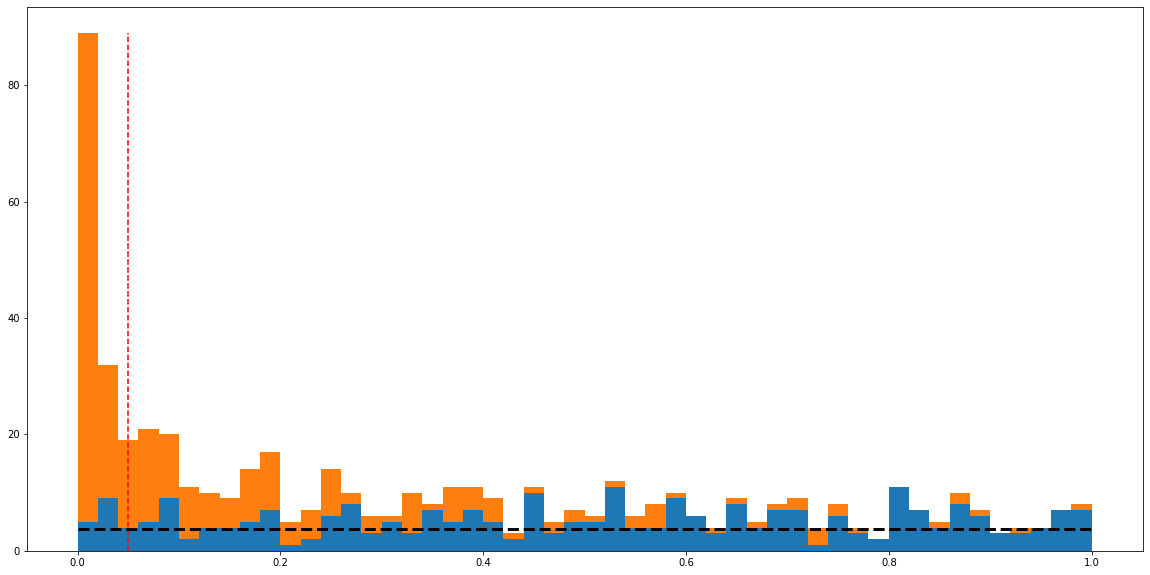

In [11]:
plot_hist_pi0(G_h0_results, G_h1_results, 50, 0.05, 0.35)



## Volcano plot (?)

# Bonus exercises

## P-value in depth
## Anova
## Counfounding
## Pi0 estimation (?)